In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p228_007.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p227_162.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p226_302.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p227_303.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p227_113.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p228_138.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p228_050.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p227_069.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p230_129.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p230_236.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p226_358.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p231_101.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p231_210.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p230_372.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p228_363.wav
/kaggle/input/noise-dataset/drdo/clean_avg_fixed/p231_134.wav
/kaggle/

In [3]:
import os
import torch
import torch.nn as nn
import numpy as np
import librosa
import soundfile as sf
from glob import glob
from torch.utils.data import Dataset, DataLoader
from IPython.display import Audio, display, clear_output
from tqdm import tqdm

# === Config
sr = 16000
duration = 3.05
length = int(sr * duration)
n_fft = 512
hop_length = 256

# === Dataset
class STFTDataset(Dataset):
    def __init__(self, clean_files, noisy_files):
        self.clean_files = clean_files
        self.noisy_files = noisy_files

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        clean, _ = librosa.load(self.clean_files[idx], sr=sr)
        noisy, _ = librosa.load(self.noisy_files[idx], sr=sr)

        clean = librosa.util.fix_length(clean, size=length)
        noisy = librosa.util.fix_length(noisy, size=length)

        clean = clean / np.max(np.abs(clean))
        noisy = noisy / np.max(np.abs(noisy))

        # === STFT (return magnitude only)
        clean_stft = librosa.stft(clean, n_fft=n_fft, hop_length=hop_length)
        noisy_stft = librosa.stft(noisy, n_fft=n_fft, hop_length=hop_length)

        clean_mag = np.abs(clean_stft)
        noisy_mag = np.abs(noisy_stft)

        return torch.tensor(noisy_mag).float(), torch.tensor(clean_mag).float()


In [4]:
class STFTDenoiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1)  # Final single-channel output
        )

    def forward(self, x):
        return self.net(x)


In [5]:
# File paths
clean_dir = "/kaggle/input/noise-dataset/drdo/clean_avg_fixed"
noisy_dir = "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy"
clean_files = sorted(glob(f"{clean_dir}/*.wav"))
noisy_files = sorted(glob(f"{noisy_dir}/*.wav"))

dataset = STFTDataset(clean_files, noisy_files)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = STFTDenoiser().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(10):
    model.train()
    total_loss = 0
    for noisy, clean in tqdm(loader, desc=f"Epoch {epoch+1}"):
        noisy = noisy.unsqueeze(1).to(device)  # (B, 1, F, T)
        clean = clean.unsqueeze(1).to(device)

        output = model(noisy)
        loss = loss_fn(output, clean)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"✅ Epoch {epoch+1} | Avg Loss: {total_loss / len(loader):.4f}")


Epoch 1: 100%|██████████| 473/473 [03:03<00:00,  2.58it/s]


✅ Epoch 1 | Avg Loss: 0.3356


Epoch 2: 100%|██████████| 473/473 [02:33<00:00,  3.09it/s]


✅ Epoch 2 | Avg Loss: 0.1983


Epoch 3: 100%|██████████| 473/473 [02:30<00:00,  3.14it/s]


✅ Epoch 3 | Avg Loss: 0.1776


Epoch 4: 100%|██████████| 473/473 [02:32<00:00,  3.10it/s]


✅ Epoch 4 | Avg Loss: 0.1616


Epoch 5: 100%|██████████| 473/473 [02:33<00:00,  3.08it/s]


✅ Epoch 5 | Avg Loss: 0.1523


Epoch 6: 100%|██████████| 473/473 [02:31<00:00,  3.12it/s]


✅ Epoch 6 | Avg Loss: 0.1474


Epoch 7: 100%|██████████| 473/473 [02:29<00:00,  3.15it/s]


✅ Epoch 7 | Avg Loss: 0.1418


Epoch 8: 100%|██████████| 473/473 [02:30<00:00,  3.14it/s]


✅ Epoch 8 | Avg Loss: 0.1390


Epoch 9: 100%|██████████| 473/473 [02:29<00:00,  3.17it/s]


✅ Epoch 9 | Avg Loss: 0.1341


Epoch 10: 100%|██████████| 473/473 [02:31<00:00,  3.13it/s]

✅ Epoch 10 | Avg Loss: 0.1328


In [6]:
# Load test audio
test_audio, _ = librosa.load(noisy_files[0], sr=sr)
test_audio = librosa.util.fix_length(test_audio, size=length)
test_audio = test_audio / np.max(np.abs(test_audio))

# STFT
test_stft = librosa.stft(test_audio, n_fft=n_fft, hop_length=hop_length)
test_mag = np.abs(test_stft)
test_phase = np.angle(test_stft)

# Predict
model.eval()
test_tensor = torch.tensor(test_mag).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    denoised_mag = model(test_tensor).squeeze().cpu().numpy()

# Reconstruct complex spectrogram
reconstructed_stft = denoised_mag * np.exp(1j * test_phase)
reconstructed_audio = librosa.istft(reconstructed_stft, hop_length=hop_length)

# Save and play
sf.write("stft_denoised.wav", reconstructed_audio, sr)
print("🎧 Denoised output saved!")
display(Audio("stft_denoised.wav", rate=sr))


🎧 Denoised output saved!


In [21]:
# ✅ 1. Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
import soundfile as sf
from glob import glob
from tqdm import tqdm
from IPython.display import Audio, display

# ✅ 2. Config
sr = 16000
duration = 3.05
length = int(sr * duration)
n_fft = 512
hop_length = 128
win_length = 512

# ✅ 3. Helper - STFT magnitude
def audio_to_mag(filepath):
    y, _ = librosa.load(filepath, sr=sr)
    y = librosa.util.fix_length(data=y, size=length)
    y = y / np.max(np.abs(y))
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mag = np.abs(stft)
    return mag.astype(np.float32)

# ✅ 4. Dataset
class SpectrogramDataset(Dataset):
    def __init__(self, clean_files, noisy_files):
        self.clean_files = clean_files
        self.noisy_files = noisy_files

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        clean_mag = audio_to_mag(self.clean_files[idx])
        noisy_mag = audio_to_mag(self.noisy_files[idx])
        return torch.tensor(noisy_mag).unsqueeze(0), torch.tensor(clean_mag).unsqueeze(0)

# ✅ 5. U-Net Model
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU())
        self.middle = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU())
        self.dec3 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU())
        self.dec2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU())
        self.dec1 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU())
        self.final = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        m = self.middle(F.max_pool2d(e3, 2))

        d3 = self.dec3(F.interpolate(m, size=e3.shape[-2:], mode='nearest'))
        d2 = self.dec2(F.interpolate(d3 + e3, size=e2.shape[-2:], mode='nearest'))
        d1 = self.dec1(F.interpolate(d2 + e2, size=e1.shape[-2:], mode='nearest'))
        out = self.final(d1 + e1)
        return out

# ✅ 6. File Paths
clean_dir = "/kaggle/input/noise-dataset/drdo/clean_avg_fixed"
noisy_dir = "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy"

clean_files = sorted(glob(f"{clean_dir}/*.wav"))
noisy_files = sorted(glob(f"{noisy_dir}/*.wav"))

# ✅ 7. Dataset + DataLoader
dataset = SpectrogramDataset(clean_files, noisy_files)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# ✅ 8. Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# ✅ 9. Training
for epoch in range(10):
    model.train()
    total_loss = 0
    for noisy, clean in tqdm(loader, desc=f"Epoch {epoch+1}"):
        noisy, clean = noisy.to(device), clean.to(device)
        output = model(noisy)

        # Match shape
        min_h = min(output.shape[2], clean.shape[2])
        min_w = min(output.shape[3], clean.shape[3])
        output = output[:, :, :min_h, :min_w]
        clean = clean[:, :, :min_h, :min_w]

        loss = loss_fn(output, clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    print(f"✅ Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

# ✅ 10. Inference on one test sample
model.eval()
test_path = noisy_files[0]
test_y, _ = librosa.load(test_path, sr=sr)
test_y = librosa.util.fix_length(data=test_y, size=length)
test_y = test_y / np.max(np.abs(test_y))

test_stft = librosa.stft(test_y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
test_mag = np.abs(test_stft)
test_tensor = torch.tensor(test_mag).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    output_mag = model(test_tensor).cpu().squeeze().numpy()

# Match shape for reconstruction
output_mag = output_mag[:test_stft.shape[0], :test_stft.shape[1]]
phase = np.angle(test_stft[:, :output_mag.shape[1]])
reconstructed = output_mag * np.exp(1j * phase)
wav = librosa.istft(reconstructed, hop_length=hop_length, win_length=win_length)

# ✅ 11. Save and Play
sf.write("denoised_output.wav", wav, sr)
print("🎧 Denoised file saved: denoised_output.wav")
display(Audio("denoised_output.wav", rate=sr))


Epoch 1: 100%|██████████| 473/473 [07:37<00:00,  1.03it/s]


✅ Epoch 1 | Avg Loss: 0.3037


Epoch 2: 100%|██████████| 473/473 [07:36<00:00,  1.04it/s]


✅ Epoch 2 | Avg Loss: 0.1202


Epoch 3: 100%|██████████| 473/473 [07:48<00:00,  1.01it/s]


✅ Epoch 3 | Avg Loss: 0.0979


Epoch 4: 100%|██████████| 473/473 [07:51<00:00,  1.00it/s]


✅ Epoch 4 | Avg Loss: 0.0909


Epoch 5: 100%|██████████| 473/473 [07:51<00:00,  1.00it/s]


✅ Epoch 5 | Avg Loss: 0.0870


Epoch 6: 100%|██████████| 473/473 [07:51<00:00,  1.00it/s]


✅ Epoch 6 | Avg Loss: 0.0799


Epoch 7: 100%|██████████| 473/473 [07:51<00:00,  1.00it/s]


✅ Epoch 7 | Avg Loss: 0.0804


Epoch 8: 100%|██████████| 473/473 [07:56<00:00,  1.01s/it]


✅ Epoch 8 | Avg Loss: 0.0747


Epoch 9: 100%|██████████| 473/473 [07:55<00:00,  1.01s/it]


✅ Epoch 9 | Avg Loss: 0.0707


Epoch 10: 100%|██████████| 473/473 [07:54<00:00,  1.00s/it]

✅ Epoch 10 | Avg Loss: 0.0686
🎧 Denoised file saved: denoised_output.wav


In [23]:
# ✅ 12. DENOISE ANY NEW FILE (not from dataset)

def denoise_custom_noisy_file(input_path, output_path="custom_denoised.wav"):
    model.eval()

    # Load and normalize
    y, _ = librosa.load(input_path, sr=sr)
    y = librosa.util.fix_length(y, size=length)
    y = y / np.max(np.abs(y))

    # Convert to STFT
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mag = np.abs(stft)
    phase = np.angle(stft)

    # Predict
    tensor = torch.tensor(mag).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        output_mag = model(tensor).cpu().squeeze().numpy()

    # Match shape
    output_mag = output_mag[:stft.shape[0], :stft.shape[1]]

    # Reconstruct
    reconstructed = output_mag * np.exp(1j * phase[:, :output_mag.shape[1]])
    denoised = librosa.istft(reconstructed, hop_length=hop_length, win_length=win_length)

    # Save
    sf.write(output_path, denoised, sr)
    print(f"✅ Saved: {output_path}")
    display(Audio(output_path, rate=sr))


# 🔹 Example Usage:
# Place any test file in your working dir and write the path
test_file_path = "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy/p226_014_explosion_radio.wav"  # 🧠 Replace with your test file name
denoise_custom_noisy_file(test_file_path, output_path="my_denoised.wav")


✅ Saved: my_denoised.wav


In [16]:
import os

def folder_stats(folder_path):
    total_size = 0
    file_count = 0

    for root, dirs, files in os.walk(folder_path):
        for f in files:
            fp = os.path.join(root, f)
            total_size += os.path.getsize(fp)
            file_count += 1

    print(f"Folder: {folder_path}")
    print(f"Number of files: {file_count}")
    print(f"Total size: {total_size / (1024**2):.2f} MB")  # in MB

# Paths for your folders
clean_folder = "/kaggle/input/noise-dataset/drdo/clean_avg_fixed"
mixed_folder = "/kaggle/input/noise-dataset/drdo/mixed_dataset"

folder_stats(clean_folder)
folder_stats(mixed_folder)


Folder: /kaggle/input/noise-dataset/drdo/clean_avg_fixed
Number of files: 1891
Total size: 176.09 MB
Folder: /kaggle/input/noise-dataset/drdo/mixed_dataset
Number of files: 1891
Total size: 176.09 MB


/tmp/ipykernel_36/3431337115.py:8: RuntimeWarning: invalid value encountered in log1p
  plt.imshow(np.log1p(output_mag), aspect='auto', origin='lower')
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


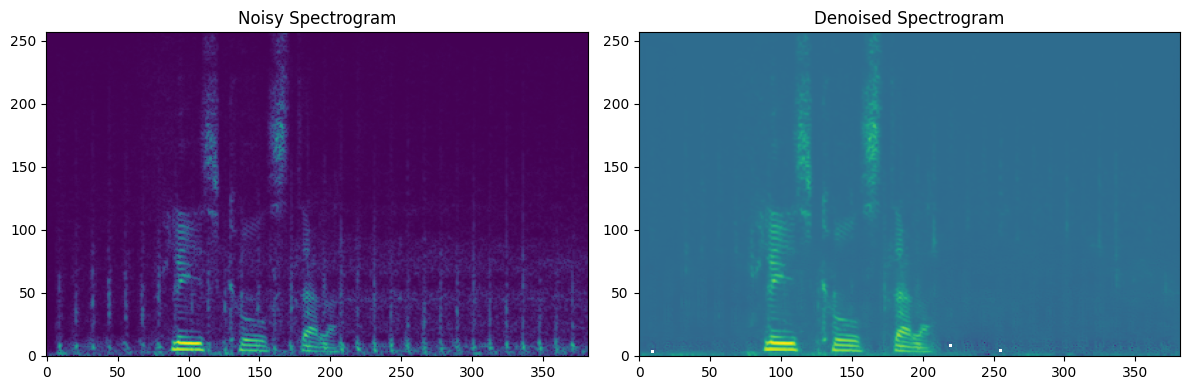

In [25]:
# Already computed: test_stft, output_mag
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.log1p(np.abs(test_stft)), aspect='auto', origin='lower')
plt.title("Noisy Spectrogram")

plt.subplot(1, 2, 2)
plt.imshow(np.log1p(output_mag), aspect='auto', origin='lower')
plt.title("Denoised Spectrogram")
plt.tight_layout()
plt.show()


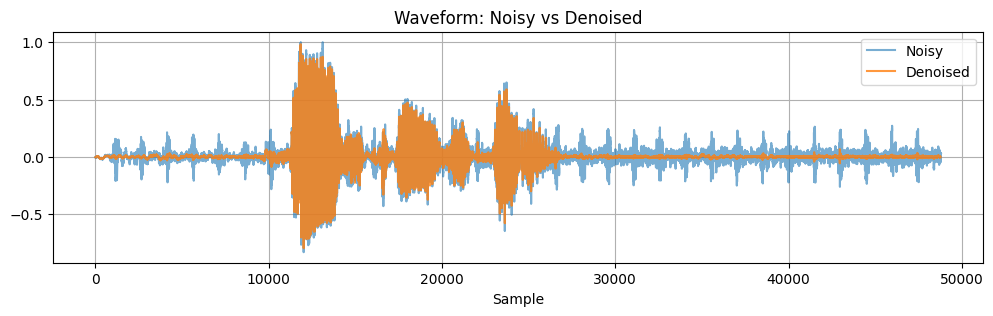

In [26]:
plt.figure(figsize=(12, 3))
plt.plot(test_y, label="Noisy", alpha=0.6)
plt.plot(wav, label="Denoised", alpha=0.8)
plt.title("Waveform: Noisy vs Denoised")
plt.xlabel("Sample")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1: 100%|██████████| 473/473 [07:42<00:00,  1.02it/s]



✅ Epoch 1 | Avg Loss: 0.3071



Epoch 2: 100%|██████████| 473/473 [07:36<00:00,  1.04it/s]



✅ Epoch 2 | Avg Loss: 0.1178



Epoch 3: 100%|██████████| 473/473 [07:46<00:00,  1.01it/s]



✅ Epoch 3 | Avg Loss: 0.0961



Epoch 4: 100%|██████████| 473/473 [07:46<00:00,  1.01it/s]



✅ Epoch 4 | Avg Loss: 0.0857



Epoch 5: 100%|██████████| 473/473 [07:44<00:00,  1.02it/s]



✅ Epoch 5 | Avg Loss: 0.0803



Epoch 6: 100%|██████████| 473/473 [07:45<00:00,  1.02it/s]



✅ Epoch 6 | Avg Loss: 0.0772



Epoch 7: 100%|██████████| 473/473 [07:45<00:00,  1.02it/s]



✅ Epoch 7 | Avg Loss: 0.0728



Epoch 8: 100%|██████████| 473/473 [07:45<00:00,  1.02it/s]



✅ Epoch 8 | Avg Loss: 0.0699



Epoch 9: 100%|██████████| 473/473 [07:40<00:00,  1.03it/s]



✅ Epoch 9 | Avg Loss: 0.0731



Epoch 10: 100%|██████████| 473/473 [07:42<00:00,  1.02it/s]



✅ Epoch 10 | Avg Loss: 0.0670



Epoch 11: 100%|██████████| 473/473 [07:37<00:00,  1.03it/s]



✅ Epoch 11 | Avg Loss: 0.0642



Epoch 12: 100%|██████████| 473/473 [07:44<00:00,  1.02it/s]



✅ Epoch 12 | Avg Loss: 0.0627



Epoch 13: 100%|██████████| 473/473 [07:44<00:00,  1.02it/s]



✅ Epoch 13 | Avg Loss: 0.0622



Epoch 14: 100%|██████████| 473/473 [07:44<00:00,  1.02it/s]



✅ Epoch 14 | Avg Loss: 0.0637



Epoch 15: 100%|██████████| 473/473 [07:46<00:00,  1.01it/s]



✅ Epoch 15 | Avg Loss: 0.0618



Epoch 16: 100%|██████████| 473/473 [07:45<00:00,  1.02it/s]



✅ Epoch 16 | Avg Loss: 0.0591



Epoch 17: 100%|██████████| 473/473 [07:43<00:00,  1.02it/s]



✅ Epoch 17 | Avg Loss: 0.0572



Epoch 18: 100%|██████████| 473/473 [07:40<00:00,  1.03it/s]



✅ Epoch 18 | Avg Loss: 0.0569



Epoch 19: 100%|██████████| 473/473 [07:46<00:00,  1.01it/s]



✅ Epoch 19 | Avg Loss: 0.0564



Epoch 20: 100%|██████████| 473/473 [07:48<00:00,  1.01it/s]



✅ Epoch 20 | Avg Loss: 0.0557



Epoch 21: 100%|██████████| 473/473 [07:48<00:00,  1.01it/s]



✅ Epoch 21 | Avg Loss: 0.0570



Epoch 22: 100%|██████████| 473/473 [07:45<00:00,  1.02it/s]



✅ Epoch 22 | Avg Loss: 0.0543



Epoch 23: 100%|██████████| 473/473 [07:47<00:00,  1.01it/s]



✅ Epoch 23 | Avg Loss: 0.0542



Epoch 24: 100%|██████████| 473/473 [07:45<00:00,  1.02it/s]



✅ Epoch 24 | Avg Loss: 0.0538



Epoch 25: 100%|██████████| 473/473 [07:46<00:00,  1.01it/s]



✅ Epoch 25 | Avg Loss: 0.0531



Epoch 26: 100%|██████████| 473/473 [07:50<00:00,  1.00it/s]



✅ Epoch 26 | Avg Loss: 0.0529



Epoch 27: 100%|██████████| 473/473 [07:47<00:00,  1.01it/s]



✅ Epoch 27 | Avg Loss: 0.0519



Epoch 28: 100%|██████████| 473/473 [07:46<00:00,  1.01it/s]



✅ Epoch 28 | Avg Loss: 0.0513



Epoch 29: 100%|██████████| 473/473 [07:47<00:00,  1.01it/s]



✅ Epoch 29 | Avg Loss: 0.0510



Epoch 30: 100%|██████████| 473/473 [07:41<00:00,  1.02it/s]



✅ Epoch 30 | Avg Loss: 0.0512



Epoch 31: 100%|██████████| 473/473 [07:43<00:00,  1.02it/s]



✅ Epoch 31 | Avg Loss: 0.0500



Epoch 32: 100%|██████████| 473/473 [07:48<00:00,  1.01it/s]



✅ Epoch 32 | Avg Loss: 0.0490



Epoch 33: 100%|██████████| 473/473 [07:44<00:00,  1.02it/s]



✅ Epoch 33 | Avg Loss: 0.0499



Epoch 34: 100%|██████████| 473/473 [07:44<00:00,  1.02it/s]



✅ Epoch 34 | Avg Loss: 0.0491



Epoch 35: 100%|██████████| 473/473 [07:42<00:00,  1.02it/s]



✅ Epoch 35 | Avg Loss: 0.0487



Epoch 36: 100%|██████████| 473/473 [07:46<00:00,  1.01it/s]



✅ Epoch 36 | Avg Loss: 0.0481



Epoch 37: 100%|██████████| 473/473 [07:43<00:00,  1.02it/s]



✅ Epoch 37 | Avg Loss: 0.0479



Epoch 38: 100%|██████████| 473/473 [07:47<00:00,  1.01it/s]



✅ Epoch 38 | Avg Loss: 0.0479



Epoch 39: 100%|██████████| 473/473 [07:42<00:00,  1.02it/s]



✅ Epoch 39 | Avg Loss: 0.0479



Epoch 40: 100%|██████████| 473/473 [07:30<00:00,  1.05it/s]



✅ Epoch 40 | Avg Loss: 0.0484



Epoch 41: 100%|██████████| 473/473 [07:38<00:00,  1.03it/s]



✅ Epoch 41 | Avg Loss: 0.0470



Epoch 42: 100%|██████████| 473/473 [07:38<00:00,  1.03it/s]



✅ Epoch 42 | Avg Loss: 0.0467



Epoch 43: 100%|██████████| 473/473 [07:39<00:00,  1.03it/s]



✅ Epoch 43 | Avg Loss: 0.0458



Epoch 44: 100%|██████████| 473/473 [07:40<00:00,  1.03it/s]



✅ Epoch 44 | Avg Loss: 0.0455



Epoch 45: 100%|██████████| 473/473 [07:40<00:00,  1.03it/s]



✅ Epoch 45 | Avg Loss: 0.0471



Epoch 46: 100%|██████████| 473/473 [07:47<00:00,  1.01it/s]



✅ Epoch 46 | Avg Loss: 0.0461



Epoch 47: 100%|██████████| 473/473 [07:46<00:00,  1.01it/s]



✅ Epoch 47 | Avg Loss: 0.0457



Epoch 48: 100%|██████████| 473/473 [07:45<00:00,  1.02it/s]



✅ Epoch 48 | Avg Loss: 0.0459



Epoch 49: 100%|██████████| 473/473 [07:44<00:00,  1.02it/s]



✅ Epoch 49 | Avg Loss: 0.0445



Epoch 50: 100%|██████████| 473/473 [07:43<00:00,  1.02it/s]



✅ Epoch 50 | Avg Loss: 0.0447



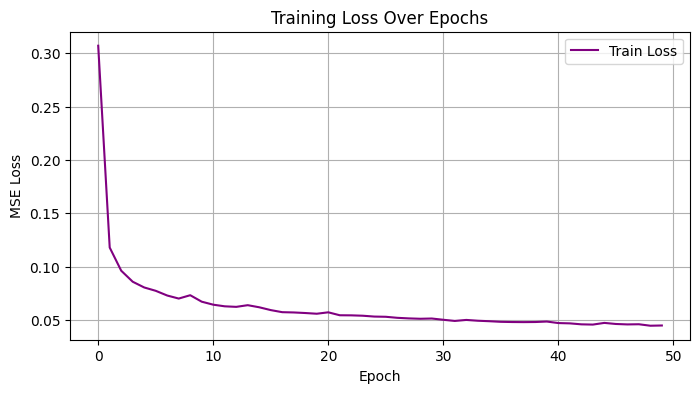

In [27]:
# ✅ 1. Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
import soundfile as sf
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# ✅ 2. Config
sr = 16000
duration = 3.05
length = int(sr * duration)
n_fft = 512
hop_length = 128
win_length = 512

# ✅ 3. Helper - STFT magnitude
def audio_to_mag(filepath):
    y, _ = librosa.load(filepath, sr=sr)
    y = librosa.util.fix_length(data=y, size=length)
    y = y / np.max(np.abs(y))
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mag = np.abs(stft)
    return mag.astype(np.float32)

# ✅ 4. Dataset
class SpectrogramDataset(Dataset):
    def __init__(self, clean_files, noisy_files):
        self.clean_files = clean_files
        self.noisy_files = noisy_files

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        clean_mag = audio_to_mag(self.clean_files[idx])
        noisy_mag = audio_to_mag(self.noisy_files[idx])
        return torch.tensor(noisy_mag).unsqueeze(0), torch.tensor(clean_mag).unsqueeze(0)

# ✅ 5. U-Net Model
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU())
        self.middle = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU())
        self.dec3 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU())
        self.dec2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU())
        self.dec1 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU())
        self.final = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        m = self.middle(F.max_pool2d(e3, 2))

        d3 = self.dec3(F.interpolate(m, size=e3.shape[-2:], mode='nearest'))
        d2 = self.dec2(F.interpolate(d3 + e3, size=e2.shape[-2:], mode='nearest'))
        d1 = self.dec1(F.interpolate(d2 + e2, size=e1.shape[-2:], mode='nearest'))
        out = self.final(d1 + e1)
        return out

# ✅ 6. File Paths
clean_dir = "/kaggle/input/noise-dataset/drdo/clean_avg_fixed"
noisy_dir = "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy"

clean_files = sorted(glob(f"{clean_dir}/*.wav"))
noisy_files = sorted(glob(f"{noisy_dir}/*.wav"))

# ✅ 7. Dataset + DataLoader
dataset = SpectrogramDataset(clean_files, noisy_files)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# ✅ 8. Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

train_losses = []

# ✅ 9. Training
for epoch in range(50):
    model.train()
    total_loss = 0
    for noisy, clean in tqdm(loader, desc=f"Epoch {epoch+1}"):
        noisy, clean = noisy.to(device), clean.to(device)
        output = model(noisy)

        # Match shape
        min_h = min(output.shape[2], clean.shape[2])
        min_w = min(output.shape[3], clean.shape[3])
        output = output[:, :, :min_h, :min_w]
        clean = clean[:, :, :min_h, :min_w]

        loss = loss_fn(output, clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    train_losses.append(avg_loss)
    print(f"\n✅ Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}\n")

# ✅ 10. Training Loss Plot
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss', color='purple')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.show()

# ✅ 11. Denoise Any File (function)
def denoise_file(model, noisy_file_path, save_dir="outputs"):
    os.makedirs(save_dir, exist_ok=True)

    y, _ = librosa.load(noisy_file_path, sr=sr)
    y = librosa.util.fix_length(y, length)
    y = y / np.max(np.abs(y))

    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mag = np.abs(stft)
    phase = np.angle(stft)

    input_tensor = torch.tensor(mag).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        out_mag = model(input_tensor).cpu().squeeze().numpy()

    out_mag = out_mag[:stft.shape[0], :stft.shape[1]]
    out_stft = out_mag * np.exp(1j * phase[:, :out_mag.shape[1]])
    out_audio = librosa.istft(out_stft, hop_length=hop_length, win_length=win_length)

    # Save and plot
    base_name = os.path.basename(noisy_file_path).replace(".wav", "_denoised.wav")
    save_path = os.path.join(save_dir, base_name)
    sf.write(save_path, out_audio, sr)

    print(f"\n🎧 Denoised file saved: {save_path}\n")
    display(Audio(save_path, rate=sr))

    # Waveform
    plt.figure(figsize=(12, 3))
    plt.plot(y, label="Noisy", alpha=0.5)
    plt.plot(out_audio, label="Denoised", alpha=0.8)
    plt.title("Waveform Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Spectrogram
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(mag, origin='lower', aspect='auto', cmap='inferno')
    plt.title("Noisy Spectrogram")
    plt.subplot(1, 2, 2)
    plt.imshow(out_mag, origin='lower', aspect='auto', cmap='inferno')
    plt.title("Denoised Spectrogram")
    plt.tight_layout()
    plt.show()

# ✅ 12. Test It
# Replace path below with any test file path
# denoise_file(model, "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy/example.wav")


In [47]:
def visualize_denoising(noisy_audio, denoised_audio, noisy_mag, denoised_mag, sr=16000):
    # ✅ 1. Waveform Comparison
    plt.figure(figsize=(12, 3))
    plt.plot(noisy_audio, label="Noisy", alpha=0.5)
    plt.plot(denoised_audio, label="Denoised", alpha=0.8)
    plt.title("Waveform Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ✅ 2. Spectrogram Comparison
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    librosa.display.specshow(librosa.amplitude_to_db(noisy_mag), sr=sr, hop_length=128, x_axis='time', y_axis='hz')
    plt.title("Noisy Spectrogram")
    plt.colorbar(format="%+2.0f dB")

    plt.subplot(1, 2, 2)
    librosa.display.specshow(librosa.amplitude_to_db(denoised_mag), sr=sr, hop_length=128, x_axis='time', y_axis='hz')
    plt.title("Denoised Spectrogram")
    plt.colorbar(format="%+2.0f dB")

    plt.tight_layout()
    plt.show()


In [49]:


denoise_file(model, "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy/p226_034_wind_radio.wav")




✅ Denoised audio saved at: denoised_outputT.wav


In [36]:
torch.save(model.state_dict(), "unet_denoiser.pth")
print(" Model saved as unet_denoiser.pth")


 Model saved as unet_denoiser.pth


In [50]:
model = UNet().to(device)
model.load_state_dict(torch.load("unet_denoiser.pth", map_location=device))
model.eval()
print("✅ Model loaded and ready for inference!")


✅ Model loaded and ready for inference!


In [51]:
noisy_file_path = "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy/p226_003_gun_radio.wav"

# Load and run
denoise_file(model, noisy_file_path)


✅ Denoised audio saved at: denoised_outputT.wav


In [53]:
import torch
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
import soundfile as sf
from IPython.display import Audio, display


In [54]:
def visualize_denoising(noisy_audio, denoised_audio, noisy_mag, denoised_mag, sr=16000):
    # Waveform
    plt.figure(figsize=(12, 3))
    plt.plot(noisy_audio, label="Noisy", alpha=0.5)
    plt.plot(denoised_audio, label="Denoised", alpha=0.8)
    plt.title("Waveform Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Spectrogram
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    librosa.display.specshow(librosa.amplitude_to_db(noisy_mag), sr=sr, hop_length=128, x_axis='time', y_axis='hz')
    plt.title("Noisy Spectrogram")
    plt.colorbar(format="%+2.0f dB")

    plt.subplot(1, 2, 2)
    librosa.display.specshow(librosa.amplitude_to_db(denoised_mag), sr=sr, hop_length=128, x_axis='time', y_axis='hz')
    plt.title("Denoised Spectrogram")
    plt.colorbar(format="%+2.0f dB")

    plt.tight_layout()
    plt.show()


In [55]:
def denoise_file(model, noisy_file_path, save_dir="outputs"):
    sr = 16000
    duration = 3.05
    length = int(sr * duration)
    n_fft = 512
    hop_length = 128
    win_length = 512

    os.makedirs(save_dir, exist_ok=True)

    y, _ = librosa.load(noisy_file_path, sr=sr)
    y = librosa.util.fix_length(y, size=length)
    y = y / np.max(np.abs(y))

    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mag = np.abs(stft)
    phase = np.angle(stft)

    input_tensor = torch.tensor(mag).unsqueeze(0).unsqueeze(0).to(model.device if hasattr(model, "device") else "cpu")
    with torch.no_grad():
        out_mag = model(input_tensor).cpu().squeeze().numpy()

    out_mag = out_mag[:stft.shape[0], :stft.shape[1]]
    out_stft = out_mag * np.exp(1j * phase[:, :out_mag.shape[1]])
    out_audio = librosa.istft(out_stft, hop_length=hop_length, win_length=win_length)

    # Save
    base_name = os.path.basename(noisy_file_path).replace(".wav", "_denoised.wav")
    save_path = os.path.join(save_dir, base_name)
    sf.write(save_path, out_audio, sr)
    print(f"✅ Denoised audio saved at: {save_path}")
    display(Audio(save_path, rate=sr))

    # 🔍 VISUALIZE
    visualize_denoising(y, out_audio, mag, out_mag)


✅ Denoised audio saved at: outputs/p226_003_gun_radio_denoised.wav


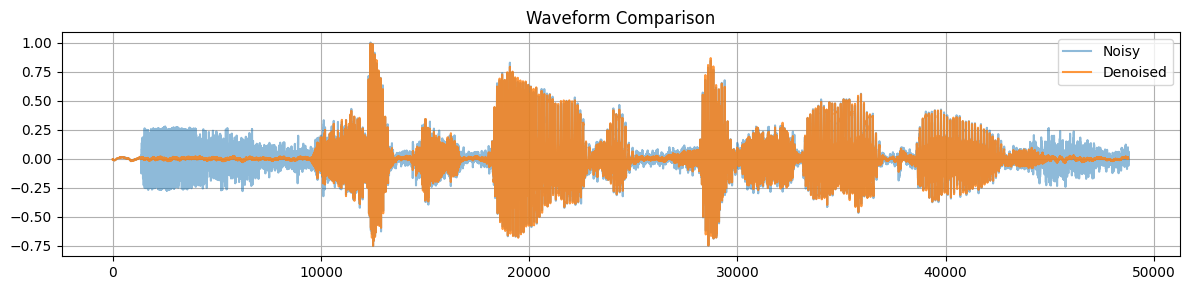

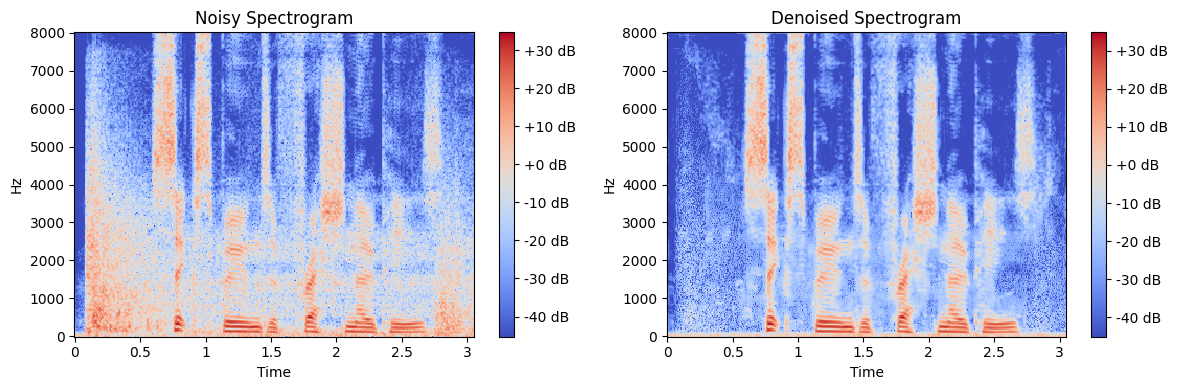

In [56]:
denoise_file(model, "/kaggle/input/noise-dataset/drdo/mixed_dataset/noisy/p226_003_gun_radio.wav")
